In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Javiera_Research')

In [ ]:
!ls

 cleaned_data  'General presentation.gslides'   notebooks


In [ ]:
!ls cleaned_data/

Codings.csv
cols_deleted.txt
df_cluster_encoded.csv
df_result_base.csv
df_result_grid.csv
fil_1yr_53cols_pos_all.csv
fil_1yr_53cols_pos_mixed.csv
fil_1yr_64cols_pos_mixed.csv
fil_1yr_66cols_pos_mixed.csv
fil_1yr_correlation_cols_pos_all.csv
fil_columns.txt
javie_filtered_cols.csv
kmeans_grid_dict.json
kmedoids_grid_dict.json
og_columns.txt
ukb43673_57cols.csv
ukb43673_61cols_1yr.csv
ukb43673_72cols.csv
ukb43673_74cols_1yr.csv
ukb43673_74cols_6mo.csv
ukb43673_76cols_1yr.csv
ukb43673_correlation_cols_1yr.csv
ukb_response_impute_ref_stats_group_ds3.csv


# Imports

In [ ]:
!pip install pyclustering

     |████████████████████████████████| 2.6MB 29.1MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-cp37-none-any.whl size=2395105 sha256=0bc9ffd9c54e6248ca7addca21e08dc236638a7fac0edf9e91998b8583dddb1a
  Stored in directory: /root/.cache/pip/wheels/d4/98/57/2f53b94ccf47805e95e189e8a18f58a51ff61d67955b79c60d
Successfully built pyclustering


In [ ]:
# !pip install scikit-learn-extra

In [ ]:
# !pip install gower

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import matplotlib.cm as cm
import matplotlib.animation as animation
import datetime
from dateutil.relativedelta import relativedelta

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.samples.definitions import FCPS_SAMPLES

# import gower

# setup linear tqdm
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# load filtered and cleaned data

In [ ]:
# df_1yr = pd.read_csv('cleaned_data/ukb43673_74cols_1yr.csv')
df = pd.read_csv('cleaned_data/fil_1yr_53cols_pos_all.csv')
  # this is the df after filter out -818 and -121 rows in all columns, both ordinal and numerical
df

,eid,31-0.0,53-2.0,20400-0.0,20458-0.0,20459-0.0,20460-0.0,20479-0.0,20485-0.0,20495-0.0,20497-0.0,20498-0.0,20505-0.0,20506-0.0,20507-0.0,20508-0.0,20509-0.0,20510-0.0,20511-0.0,20512-0.0,20513-0.0,20514-0.0,20515-0.0,20516-0.0,20517-0.0,20518-0.0,20519-0.0,20520-0.0,21003-2.0,21023-0.0,21025-0.0,21033-0.0,21034-0.0,21040-0.0,21041-0.0,21042-0.0,21043-0.0,21044-0.0,21048-0.0,21049-0.0,21051-0.0,21052-0.0,21053-0.0,21054-0.0,21055-0.0,21056-0.0,21057-0.0,21058-0.0,21059-0.0,21060-0.0,21061-0.0,center2_time_lapse1,center2_time_lapse2
0,1000993,1.0,2017-06-21,2016-07-28,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,59.0,2017-04-11,0.0,-500.0,-501.0,1.0,0.0,3.0,5.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,328 days,71 days
1,1001367,1.0,2017-08-16,2016-09-30,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,78.0,2017-08-24,4.0,-503.0,-501.0,8.0,0.0,1.0,7.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,320 days,-8 days
2,1003110,1.0,2016-05-25,2016-08-18,2.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,64.0,2017-04-28,0.0,-500.0,-501.0,1.0,0.0,2.0,6.0,1.0,-600.0,-602.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-85 days,-338 days
3,1003823,1.0,2016-05-31,2016-08-24,2.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,59.0,2017-05-05,0.0,-501.0,-500.0,1.0,2.0,2.0,3.0,1.0,-600.0,-601.0,-601.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-601.0,-85 days,-339 days
4,1004315,0.0,2017-09-15,2017-04-25,4.0,5.0,3.0,2.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,1.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,3.0,2.0,53.0,2017-04-25,3.0,-500.0,-501.0,1.0,1.0,2.0,5.0,1.0,-601.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,-313.0,-600.0,-601.0,-602.0,-601.0,143 days,143 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,6021110,1.0,2016-07-25,2016-08-19,3.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,2017-05-04,1.0,-500.0,-500.0,1.0,0.0,3.0,1.0,2.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-313.0,-600.0,-600.0,-600.0,-600.0,-25 days,-283 days
5768,6022430,1.0,2016-12-18,2016-12-12,1.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.0,2017-04-28,0.0,-500.0,-500.0,2.0,0.0,2.0,7.0,1.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-602.0,-600.0,-600.0,-601.0,6 days,-131 days
5769,6022902,1.0,2017-09-09,2016-09-22,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.0,2017-05-20,5.0,-501.0,-501.0,2.0,5.0,2.0,3.0,1.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-600.0,-600.0,-600.0,352 days,112 days
5770,6023768,0.0,2017-06-18,2016-08-17,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,57.0,2017-04-26,5.0,-500.0,-501.0,10.0,8.0,2.0,7.0,1.0,-601.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-601.0,305 days,53 days


# remove attributes not used for clustering

In [ ]:
df.dtypes[(df.dtypes=='object')]

53-2.0                 object
20400-0.0              object
21023-0.0              object
center2_time_lapse1    object
center2_time_lapse2    object
dtype: object

In [ ]:
time_cols = list(df.dtypes[(df.dtypes=='object')].index)

In [ ]:
# all of those columns are date columns
  # date of attending center
  # date of mental health questionaire
  # date of digestive questionaire
  # and the 2 time lapses

df_clus = df.drop(time_cols, axis='columns').copy()
  # we should not use time columns for cluster

In [ ]:
# also remove the sex column and the 2 age columns
# they are insightful to our analysis but should not be used to predict clusters!
df_clus.drop(columns=['31-0.0', '21003-2.0'], inplace=True)
  # we only ahve 1 age column now because age for center 3 is not included in this data yet

In [ ]:
df_clus.set_index('eid', drop=True, inplace=True)
  # set eid as our index because it is not really a feature

In [ ]:
print(df_clus.shape)

(5772, 45)


# Encode categorical columns

In [ ]:
# load Andrews csv to get a list of the data types for each column
# categorical or integer
meta_df = pd.read_csv('cleaned_data/javie_filtered_cols.csv')
meta_df_cols = meta_df[['UDI','type']]

In [ ]:
# because we mannually added two 2 columns to this list, add them to the df
# other columns we added do not need to be considered anyways
i = len(meta_df_cols)
meta_df_cols.loc[i] = ['21003-2.0', 'numerical']
  # age for center 2
meta_df_cols.loc[i+1] = ['31-0.0', 'ordinal']
  # sex

meta_df_cols.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(51, 2)

In [ ]:
meta_df_cols = meta_df_cols[meta_df_cols['UDI'].isin(df_clus.columns)]
  # keep the meta for columns that are actually in our dataframe

meta_df_cols.shape

(45, 2)

In [ ]:
meta_df_cols[meta_df_cols['type'] == 'numerical']

,UDI,type
0,21044-0.0,numerical
19,21042-0.0,numerical
20,21043-0.0,numerical
21,21040-0.0,numerical


In [ ]:
int_cols = list(meta_df_cols[meta_df_cols['type'] == 'numerical']['UDI'])
  # these are the only numerical columns
  # the rest of the columns are categorical
int_cols

['21044-0.0', '21042-0.0', '21043-0.0', '21040-0.0']

In [ ]:
cat_cols = list(df_clus.columns[~df_clus.columns.isin(int_cols)])
len(cat_cols)
  # 53 (- 5 - 2 - 1 )- 4 = 40

41

In [ ]:
(df_clus['21059-0.0'].unique())

array([-600., -601., -602.])

In [ ]:
# ordinal encode the ordinal columns only
df_clus_encoded = df_clus.copy()
oe = preprocessing.OrdinalEncoder()
df_clus_encoded[cat_cols] = oe.fit_transform(df_clus[cat_cols])

In [ ]:
(df_clus_encoded['21059-0.0'].unique())

array([2., 1., 0.])

In [ ]:
df_clus.shape == df_clus_encoded.shape

True

In [ ]:
# later, transform back with 
# df_clus_encoded[cat_cols] = oe.inverse_transform(df_clus[cat_cols])

In [ ]:
int_cols

['21044-0.0', '21042-0.0', '21043-0.0', '21040-0.0']

In [ ]:
for i in range(len(int_cols)):
    print(list(df_clus_encoded.columns).index(int_cols[i]))
# these are the indices of integer columns in the list of all columns
# these will be used to plot pairwise clsuters later

31
29
30
27


In [ ]:
list(df_clus_encoded.columns)[31]

'21044-0.0'

## save encoded dataset with cluster features only

In [ ]:
df_clus_encoded.shape

(5772, 45)

In [ ]:
# save to csv file WITH INDEX for easier loading later
df_clus_encoded.to_csv('cleaned_data/df_cluster_encoded.csv')

# k-medoids example

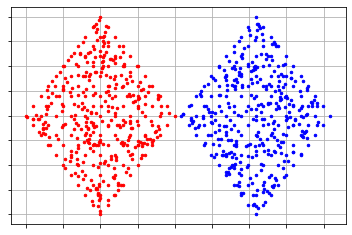

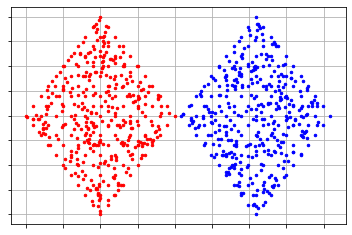

In [ ]:
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)
# Set random initial medoids.
initial_medoids = [1, 500]
# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(sample, initial_medoids)
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
# Show allocated clusters.
# print(clusters)
# Display clusters.
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.show()

# k-medoids with euclidean distance on our data

In [ ]:
!ls cleaned_data/

Codings.csv
cols_deleted.txt
df_cluster_encoded.csv
df_result_base.csv
df_result_grid.csv
fil_1yr_53cols_pos_all.csv
fil_1yr_53cols_pos_mixed.csv
fil_1yr_64cols_pos_mixed.csv
fil_1yr_66cols_pos_mixed.csv
fil_1yr_correlation_cols_pos_all.csv
fil_columns.txt
javie_filtered_cols.csv
kmeans_grid_dict.json
kmedoids_grid_dict.json
og_columns.txt
ukb43673_57cols.csv
ukb43673_61cols_1yr.csv
ukb43673_72cols.csv
ukb43673_74cols_1yr.csv
ukb43673_74cols_6mo.csv
ukb43673_76cols_1yr.csv
ukb43673_correlation_cols_1yr.csv
ukb_response_impute_ref_stats_group_ds3.csv


In [ ]:
df_clus_encoded = pd.read_csv('cleaned_data/df_cluster_encoded.csv')

# since this df was saved WITH the index, we have to re-assign it as the index and drop it from the columns
df_clus_encoded.set_index('eid',inplace=True)

df_clus_encoded.shape
  # should be (5772,45)

(5772, 45)

In [ ]:
my_mm_scaler = MinMaxScaler()  
# my_scaler = StandardScaler()
  # this is the only scaler that works with PCA later
  # but is this the best scaler for clustering purposes?
  # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
my_mm_scaler.fit(df_clus_encoded)  

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
# tranform returns a numpy array which is perfect to pass into the kmedoids function
df_clus_encoded_mm = my_mm_scaler.transform(df_clus_encoded)

In [ ]:
df_clus_encoded_mm.min(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
df_clus_encoded_mm.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# Set random initial medoids, randomly choose 5 indices (for 5 clusters) from all available indices
initial_medoids = np.random.randint(0, df_clus_encoded_mm.shape[0],5)
initial_medoids

array([4582,  781, 3244, 4250, 5459])

In [ ]:
# create euclidean distance metric
metric = distance_metric(type_metric.EUCLIDEAN)

# Create instance of K-Medoids algorithm.
kmedoids_instance = kmedoids(df_clus_encoded_mm.tolist(), 
                             initial_medoids,
                             metric=metric)
# Run cluster analysis and obtain results.
# cluster only runs on a list of lists
kmedoids_instance.process()

In [ ]:
metric([0,0], [5,12])
  # the metric just finds the shortest distance between two points in an N dimensional space

13.0

In [ ]:
# show the row index that are the center medoids for each cluster
final_medoids = kmedoids_instance.get_medoids()
final_medoids

[5219, 1996, 2921, 533, 3690]

In [ ]:
kmedoids_clusters = kmedoids_instance.get_clusters()
# Show allocated clusters
# each list is a cluster and contains the index of the rows in that cluster, in increasing order
len(kmedoids_clusters)
for i in kmedoids_clusters:
  print(i)

[2, 5, 7, 9, 12, 13, 22, 24, 26, 34, 36, 50, 51, 52, 56, 58, 60, 87, 101, 113, 125, 136, 143, 144, 158, 176, 190, 192, 198, 199, 202, 215, 223, 236, 238, 245, 249, 272, 274, 280, 281, 286, 306, 311, 317, 347, 365, 369, 383, 385, 392, 398, 404, 407, 411, 412, 422, 425, 426, 428, 440, 447, 470, 484, 496, 499, 502, 504, 505, 512, 514, 515, 518, 539, 544, 551, 564, 576, 577, 598, 600, 603, 619, 622, 629, 630, 662, 667, 671, 677, 692, 705, 707, 708, 714, 722, 732, 736, 737, 742, 745, 751, 765, 766, 769, 770, 776, 779, 791, 794, 795, 798, 810, 825, 835, 848, 853, 860, 866, 868, 871, 882, 886, 890, 892, 893, 894, 896, 898, 901, 905, 913, 921, 923, 925, 933, 935, 936, 938, 944, 946, 963, 975, 978, 991, 993, 1020, 1025, 1026, 1052, 1053, 1060, 1064, 1072, 1073, 1079, 1092, 1095, 1099, 1108, 1112, 1118, 1121, 1122, 1124, 1127, 1141, 1145, 1153, 1158, 1173, 1176, 1180, 1182, 1196, 1211, 1217, 1227, 1228, 1231, 1236, 1239, 1246, 1249, 1265, 1272, 1274, 1278, 1280, 1289, 1292, 1293, 1302, 1305, 131

In [ ]:
# sort so order can be compared with kmeans later
kmedoids_clusters.sort()
for i in kmedoids_clusters:
  print(i)

[0, 1, 3, 6, 11, 16, 19, 25, 38, 42, 43, 46, 53, 57, 59, 61, 67, 71, 72, 74, 83, 84, 85, 86, 92, 94, 95, 96, 98, 103, 104, 105, 106, 110, 115, 121, 123, 126, 127, 130, 132, 137, 152, 156, 165, 168, 169, 173, 174, 177, 178, 179, 197, 201, 204, 208, 211, 216, 220, 230, 231, 232, 241, 243, 246, 247, 248, 261, 263, 266, 275, 279, 285, 287, 305, 307, 309, 313, 314, 316, 318, 319, 324, 326, 328, 331, 332, 335, 340, 342, 343, 348, 358, 359, 368, 372, 373, 374, 389, 390, 391, 394, 396, 409, 415, 416, 418, 420, 423, 424, 451, 452, 454, 455, 456, 458, 460, 462, 464, 465, 471, 476, 491, 493, 495, 507, 508, 511, 517, 521, 525, 526, 529, 531, 540, 541, 543, 553, 557, 558, 565, 568, 575, 578, 583, 586, 590, 591, 592, 593, 596, 614, 625, 633, 635, 641, 646, 647, 653, 655, 656, 668, 669, 674, 678, 683, 684, 690, 696, 700, 702, 704, 711, 723, 726, 730, 735, 738, 743, 747, 752, 755, 762, 768, 778, 781, 790, 806, 807, 808, 811, 812, 814, 822, 823, 826, 831, 836, 838, 839, 849, 851, 857, 864, 867, 873, 87

## add baseline results to **original** dataframe

In [ ]:
# add cluster results to the original dataframe, where no features were encoded nor scaled nor removed

df_result_base = df.copy()
df_result_base['kmedoid_cluster'] = np.zeros(len(df_result_base))
  # create a new column indicating the kmedoid cluster results

for i in range(len(kmedoids_clusters)):
  # assign cluster number to the rows
  rows=kmedoids_clusters[i]
  col = df_result_base.columns.get_loc('kmedoid_cluster')
  print(i, len(rows))
  df_result_base.iloc[rows, col] = int(i+1)*np.ones(len(rows))

0 1060
1 974
2 1280
3 1103
4 1355


In [ ]:
# make sure assignment is correct
df_result_base.groupby('kmedoid_cluster').count().iloc[:,0]

kmedoid_cluster
1.0    1060
2.0     974
3.0    1280
4.0    1103
5.0    1355
Name: eid, dtype: int64

## 2-comp PCA visualization

In [ ]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
# my_st_scaler.fit(df_clus_encoded)  

# # tranform returns a numpy array which is perfect to pass into the kmedoids function
# df_clus_encoded_st = my_st_scaler.transform(df_clus_encoded)

In [ ]:
# instantiate PCA object
my_pca2 = PCA(n_components=2)

df_clus_encoded_mm_pca2 = my_pca2.fit_transform(df_clus_encoded_mm)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [ ]:
# look into variance explained
print(my_pca2.explained_variance_)
  # The variance i.e. the eigenvalues of the covariance matrix
  # The amount of variance explained by each of the selected components.
print(my_pca2.explained_variance_ratio_)
  # Percentage of variance explained by each of the selected components versue overall variance in the og data.
  # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
print(my_pca2.explained_variance_ratio_.cumsum())

[0.53793528 0.24692975]
[0.20855758 0.0957347 ]
[0.20855758 0.30429228]


In [ ]:
print(df_clus_encoded_mm.shape)
print(df_clus_encoded_mm_pca2.shape)

(5772, 47)
(5772, 2)


In [ ]:
len(df_clus_encoded_mm_pca2[kmedoids_clusters[0]][:,0])

1276

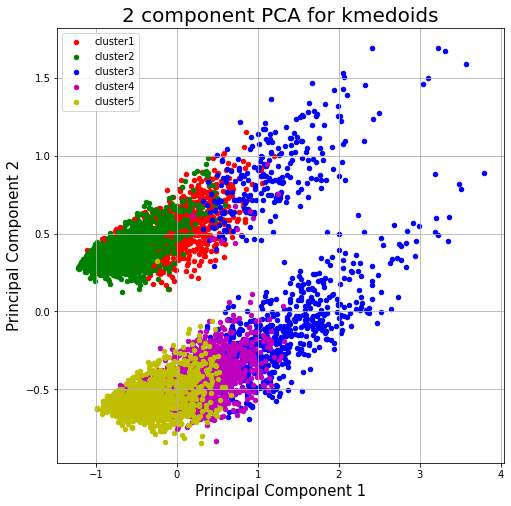

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for kmedoids', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmedoids_clusters)):
  # for each cluster
  arr=df_clus_encoded_mm_pca2[kmedoids_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], 
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i], 
             s = 20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

plt.show()

## 3-comp PCA visualization

In [ ]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
# my_st_scaler.fit(df_clus_encoded)  

# # tranform returns a numpy array which is perfect to pass into the kmedoids function
# df_clus_encoded_st = my_st_scaler.transform(df_clus_encoded)

In [ ]:
# instantiate PCA object
my_pca3 = PCA(n_components=3)
df_clus_encoded_mm_pca3 = my_pca3.fit_transform(df_clus_encoded_mm)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [ ]:
# look into variance explained
print(my_pca3.explained_variance_)
  # The variance i.e. the eigenvalues of the covariance matrix
  # The amount of variance explained by each of the selected components.
print(my_pca3.explained_variance_ratio_)
  # Percentage of variance explained by each of the selected components versue overall variance in the og data.
  # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
print(my_pca3.explained_variance_ratio_.cumsum())

[0.53793528 0.24692975 0.18931313]
[0.20855758 0.0957347  0.07339673]
[0.20855758 0.30429228 0.37768901]


In [ ]:
print(df_clus_encoded_mm.shape)
print(df_clus_encoded_mm_pca3.shape)

(5772, 47)
(5772, 3)


In [ ]:
len(df_clus_encoded_mm_pca3[kmedoids_clusters[0]][:,0])

1276

matplotlib.axes._subplots.Axes3DSubplot

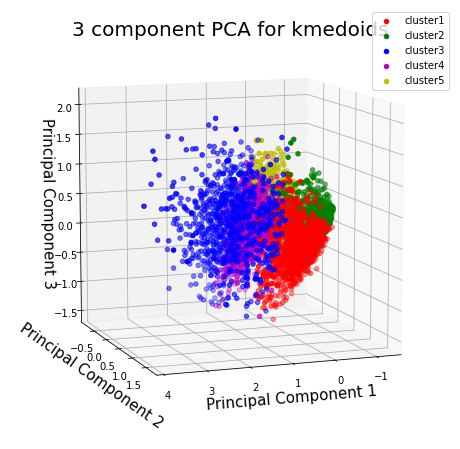

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA for kmedoids', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmedoids_clusters)):
  # for each cluster
  arr=df_clus_encoded_mm_pca3[kmedoids_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], arr[:,2],
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i],
             s=20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

# try different rotation angles here
ax.azim = 70
  # The azimuth is the rotation around the z axis e.g.:
  # 0 means "looking from +x"
  # 90 means "looking from +y"
ax.elev = 10
  #elev is the angle between the eye and the xy plane.
# ax.dist = 100
  # dist is the distance from the center visible point in data coordinates.
type(ax)

In [ ]:
!ls

 cleaned_data  'General presentation.gslides'   notebooks


## 2-comp TSNE visualization

In [ ]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
# my_st_scaler.fit(df_clus_encoded)  

# # tranform returns a numpy array which is perfect to pass into the kmedoids function
# df_clus_encoded_st = my_st_scaler.transform(df_clus_encoded)

In [ ]:
# instantiate tsne object
my_tsne2 = TSNE(n_components=2)

df_clus_encoded_mm_tsne2 = my_tsne2.fit_transform(df_clus_encoded_mm)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [ ]:
# # look into variance explained
# print(my_pca2.explained_variance_)
#   # The variance i.e. the eigenvalues of the covariance matrix
#   # The amount of variance explained by each of the selected components.
# print(my_pca2.explained_variance_ratio_)
#   # Percentage of variance explained by each of the selected components versue overall variance in the og data.
#   # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
# print(my_pca2.explained_variance_ratio_.cumsum())

In [ ]:
# look into Kullback-Leibler divergence after optimization.
# the lower the better
my_tsne2.kl_divergence_

2.489746332168579

In [ ]:
print(df_clus_encoded_mm.shape)
print(df_clus_encoded_mm_tsne2.shape)

(5772, 45)
(5772, 2)


In [ ]:
len(df_clus_encoded_mm_tsne2[kmedoids_clusters[0]][:,0])

1240

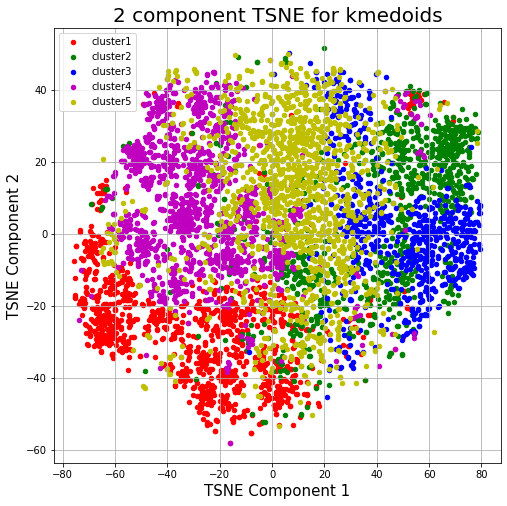

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE Component 1', fontsize = 15)
ax.set_ylabel('TSNE Component 2', fontsize = 15)
ax.set_title('2 component TSNE for kmedoids', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmedoids_clusters)):
  # for each cluster
  arr=df_clus_encoded_mm_tsne2[kmedoids_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], 
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i], 
             s = 20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

plt.show()

## 3-comp TSNE visualization

In [ ]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
# my_st_scaler.fit(df_clus_encoded)  

# # tranform returns a numpy array which is perfect to pass into the kmedoids function
# df_clus_encoded_st = my_st_scaler.transform(df_clus_encoded)

In [ ]:
# instantiate TSNE object
my_tsne3 = TSNE(n_components=3)
df_clus_encoded_mm_tsne3 = my_tsne3.fit_transform(df_clus_encoded_mm)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [ ]:
# # look into variance explained
# print(my_pca3.explained_variance_)
#   # The variance i.e. the eigenvalues of the covariance matrix
#   # The amount of variance explained by each of the selected components.
# print(my_pca3.explained_variance_ratio_)
#   # Percentage of variance explained by each of the selected components versue overall variance in the og data.
#   # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
# print(my_pca3.explained_variance_ratio_.cumsum())

In [ ]:
# look into Kullback-Leibler divergence after optimization.
# the lower the better
my_tsne3.kl_divergence_

2.3159985542297363

In [ ]:
print(df_clus_encoded_mm.shape)
print(df_clus_encoded_mm_tsne3.shape)

(5772, 45)
(5772, 3)


In [ ]:
len(df_clus_encoded_mm_tsne3[kmedoids_clusters[0]][:,0])

1240

matplotlib.axes._subplots.Axes3DSubplot

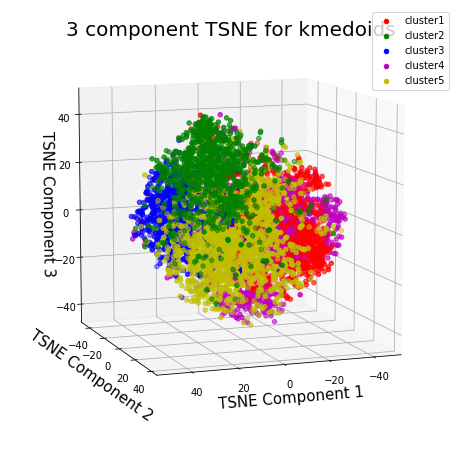

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('TSNE Component 1', fontsize = 15)
ax.set_ylabel('TSNE Component 2', fontsize = 15)
ax.set_zlabel('TSNE Component 3', fontsize = 15)
ax.set_title('3 component TSNE for kmedoids', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmedoids_clusters)):
  # for each cluster
  arr=df_clus_encoded_mm_tsne3[kmedoids_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], arr[:,2],
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i],
             s=20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

# try different rotation angles here
ax.azim = 70
  # The azimuth is the rotation around the z axis e.g.:
  # 0 means "looking from +x"
  # 90 means "looking from +y"
ax.elev = 10
  #elev is the angle between the eye and the xy plane.
# ax.dist = 100
  # dist is the distance from the center visible point in data coordinates.
type(ax)

In [ ]:
!ls

 cleaned_data  'General presentation.gslides'   notebooks


## `pyclustering` pairwise visualization

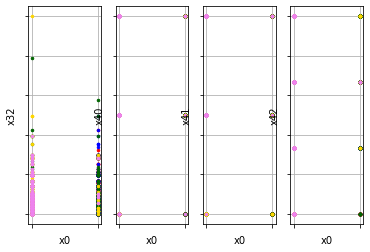

In [ ]:
# Display clusters.
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(kmedoids_clusters, df_clus_encoded_mm.tolist())
  # only works with a list of lists, does NOT work with np array
visualizer.show(pair_filter=[[0, 32], [0, 40],[0,41],[0,42]])
# visualizer.show(max_row_size=3)

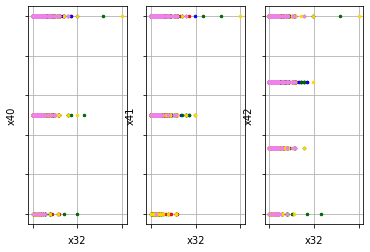

In [ ]:
visualizer.show(pair_filter=[[32, 40],[32,41],[32,42]])

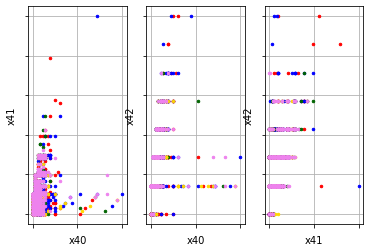

In [ ]:
visualizer.show(pair_filter=[[40,41],[40,42],[41,42]])

# grid-search for best `kmedoids`


In [ ]:
df_clus_encoded = pd.read_csv('cleaned_data/df_cluster_encoded.csv')

# since this df was saved WITH the index, we have to re-assign it as the index and drop it from the columns
df_clus_encoded.set_index('eid',inplace=True)

df_clus_encoded.shape
  # should be (5772,45)

(5772, 45)

In [ ]:
my_mm_scaler = MinMaxScaler()  
# my_scaler = StandardScaler()
  # this is the only scaler that works with PCA later
  # but is this the best scaler for clustering purposes?
  # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
my_mm_scaler.fit(df_clus_encoded)  

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
# tranform returns a numpy array which is perfect to pass into the kmedoids function
df_clus_encoded_mm = my_mm_scaler.transform(df_clus_encoded)

In [ ]:
len(df_clus_encoded_mm[0,:])

45

This is the definition of the `.get_total_wce()` method in the `kmeans` class, we should write something similar for our `kmedoids` algorithm.

```
     def __calculate_dataset_difference(self, amount_clusters):
         """!
         @brief Calculate distance from each point to each cluster center.
 
         """
         dataset_differences = numpy.zeros((amount_clusters, len(self.__pointer_data)))
         for index_center in range(amount_clusters):
             if self.__metric.get_type() != type_metric.USER_DEFINED:
                 dataset_differences[index_center] = self.__metric(self.__pointer_data, self.__centers[index_center])
             else:
                 dataset_differences[index_center] = [ self.__metric(point, self.__centers[index_center])
                                                       for point in self.__pointer_data ]
 
         return dataset_differences


     def __calculate_total_wce(self):
         """!
         @brief Calculate total within cluster errors that is depend on metric that was chosen for K-Means algorithm.
 
         """
 
         dataset_differences = self.__calculate_dataset_difference(len(self.__clusters))
 
         self.__total_wce = 0
         for index_cluster in range(len(self.__clusters)):
             for index_point in self.__clusters[index_cluster]:
                 self.__total_wce += dataset_differences[index_cluster][index_point]
```



In [ ]:
# since kmedoids does not have a .get_total_wce method
# we must manually design a function that returns sum of metric errors
# make sure it is the Sum of Squared Errors where each error is calculated using the metric the algorithm was trained on
# this matches how the kmeans internal function does it
def kmedoid_total_sse(metric, data, medoids, clusters):
  '''
  input:
    metric: the distance_metric object used by the clutering algoritm
    data: the data in numpy arrays containing the points
    medoids: a list of indices of medoids of the final clusters
    clusters: a list of clusters, where each cluster is a list of indices in that cluster, 
              cannot be sorted and must be in the same order as medoids list
  output:
    the total sum of squared errors of between points and their cluster centers using the metric
  '''
  sse = 0
  assert len(medoids) == len(clusters)
  for i in range(len(medoids)):
    # for each center
    c = medoids[i] # index of cluster center
    center = data[c, :] # actual center point
    for j in clusters[i]:
      # for each index in the cluster with that center
      pt = data[j, :] # actual point in data
      sse += metric(pt,center) # error between point and center

  return sse

In [ ]:
# create euclidean distance metric
metric = distance_metric(type_metric.EUCLIDEAN)

In [ ]:
metric([0,0], [5,12])
  # the metric just finds the shortest distance between two points in an N dimensional space

13.0

In [ ]:
k_lst = [i for i in range(2,31)]
kmedoid_error_lst=[]
kmedoid_center_lst=[]
kmedoid_sorted_clusters_lst=[]

for k in tqdm(k_lst):
  # print(k)
  # Set random initial medoids, randomly choose k indices (for k clusters) from all available indices
  initial_medoids = np.random.randint(0, df_clus_encoded_mm.shape[0],k)

  # Create instance of K-Medoids algorithm.
  kmedoids_instance = kmedoids(df_clus_encoded_mm.tolist(), 
                              initial_medoids,
                              metric=metric)
  
  # Run cluster analysis and obtain results.
  # cluster only runs on a list of lists
  kmedoids_instance.process()

  # show the row index that are the center medoids for each cluster
  final_medoids = kmedoids_instance.get_medoids()
  kmedoid_center_lst.append(final_medoids)

  # Show allocated clusters
  # each list is a cluster and contains the index of the rows in that cluster
  kmedoids_clusters = kmedoids_instance.get_clusters()

  # use unsorted cluster for error, so order is the same as center
  total_error = kmedoid_total_sse(metric, df_clus_encoded_mm, final_medoids, kmedoids_clusters)
  kmedoid_error_lst.append(total_error)

  # sort and save so order can be compared with kmeans later
  kmedoids_clusters.sort()
  kmedoid_sorted_clusters_lst.append(kmedoids_clusters)

100%|██████████| 29/29 [7:19:54<00:00, 910.14s/it] 


In [ ]:
len(final_medoids)

30

In [ ]:
kmedoid_i = kmedoid_error_lst.index(min(kmedoid_error_lst))

print(f'lowest SSE for kmedoid: {kmedoid_error_lst[kmedoid_i]}')
print(f'best k for kmedoid: {k_lst[kmedoid_i]}')

lowest SSE for kmedoid: 6990.442329785987
best k for kmedoid: 30


Text(0.5, 1.0, 'grid search for kmeans')

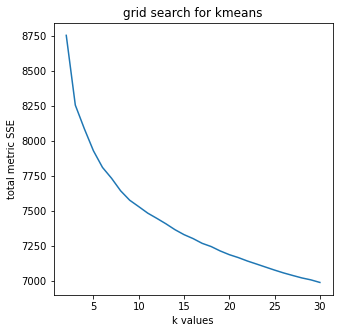

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(k_lst, kmedoid_error_lst)
plt.xlabel("k values")
plt.ylabel("total metric SSE")
plt.title("grid search for kmeans")

In [ ]:
kmedoids_grid_dict = {'k_lst': k_lst,
                      'error_lst': kmedoid_error_lst,
                      'center_lst': kmedoid_center_lst,
                      'sorted_clusters_lst': kmedoid_sorted_clusters_lst}

In [ ]:
# save the grid search results for loading later
with open('cleaned_data/kmedoids_grid_dict.json', 'w') as fp:
    json.dump(kmedoids_grid_dict, fp, indent=4)



## add grid-search results to **original** dataframe

add `k=13~4`

In [ ]:
# later load with
with open('cleaned_data/kmedoids_grid_dict.json', 'r') as fp:
    kmedoids_grid_dict = json.load(fp)

k_lst = kmedoids_grid_dict['k_lst']
kmedoid_error_lst = kmedoids_grid_dict['error_lst']
kmedoid_center_lst = kmedoids_grid_dict['center_lst']
kmedoid_sorted_clusters_lst = kmedoids_grid_dict['sorted_clusters_lst']

In [ ]:
# add cluster results to the original dataframe, where no features were encoded nor scaled nor removed
# but all rows where cleaned so we do not have NA or negative values

df_result_grid = df.copy()


ks = [13,12,11,10,9,8,7,6,5,4]

for k in ks: # for each k value of interest
  i = k_lst.index(k)
    # find the index of the k value of interest
  print(f'k-value:{k} is index {i}')

  feat = 'kmedoid_cluster_' + str(k)
  print(f'adding column {feat}')

  df_result_grid[feat] = np.zeros(len(df_result_grid))
  # create a new column indicating the kmedoid cluster with k clusters results

  kmedoids_clusters = kmedoid_sorted_clusters_lst[i]
  # grab the cluster results trained with the k-value

  assert len(kmedoids_clusters) == k
    # make sure the number of clusters in the result match the chosen k
  
  for i in range(len(kmedoids_clusters)): # for each cluster_i in the cluster_lst of the k
    # assign cluster number to the rows
    rows=kmedoids_clusters[i]
      # get the row indices of samples in clustier_i
    col = df_result_grid.columns.get_loc(feat)
      # get the column indes of the particular k-value 
    
    # df_result_grid.iloc[rows, col] = int(i+1), same as below
    df_result_grid.iloc[rows, col] = int(i+1)*np.ones(len(rows))
      # assign the cluster number to those rows of a particular k-kmedoid

k-value:13 is index 11
adding column kmedoid_cluster_13
k-value:12 is index 10
adding column kmedoid_cluster_12
k-value:11 is index 9
adding column kmedoid_cluster_11
k-value:10 is index 8
adding column kmedoid_cluster_10
k-value:9 is index 7
adding column kmedoid_cluster_9
k-value:8 is index 6
adding column kmedoid_cluster_8
k-value:7 is index 5
adding column kmedoid_cluster_7
k-value:6 is index 4
adding column kmedoid_cluster_6
k-value:5 is index 3
adding column kmedoid_cluster_5
k-value:4 is index 2
adding column kmedoid_cluster_4


In [ ]:
df_result_grid.head()

,eid,31-0.0,53-2.0,20400-0.0,20458-0.0,20459-0.0,20460-0.0,20479-0.0,20485-0.0,20495-0.0,20497-0.0,20498-0.0,20505-0.0,20506-0.0,20507-0.0,20508-0.0,20509-0.0,20510-0.0,20511-0.0,20512-0.0,20513-0.0,20514-0.0,20515-0.0,20516-0.0,20517-0.0,20518-0.0,20519-0.0,20520-0.0,21003-2.0,21023-0.0,21025-0.0,21033-0.0,21034-0.0,21040-0.0,21041-0.0,21042-0.0,21043-0.0,21044-0.0,21048-0.0,21049-0.0,21051-0.0,21052-0.0,21053-0.0,21054-0.0,21055-0.0,21056-0.0,21057-0.0,21058-0.0,21059-0.0,21060-0.0,21061-0.0,center2_time_lapse1,center2_time_lapse2,kmedoid_cluster_13,kmedoid_cluster_12,kmedoid_cluster_11,kmedoid_cluster_10,kmedoid_cluster_9,kmedoid_cluster_8,kmedoid_cluster_7,kmedoid_cluster_6,kmedoid_cluster_5,kmedoid_cluster_4
0,1000993,1.0,2017-06-21,2016-07-28,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,59.0,2017-04-11,0.0,-500.0,-501.0,1.0,0.0,3.0,5.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,328 days,71 days,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1001367,1.0,2017-08-16,2016-09-30,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,78.0,2017-08-24,4.0,-503.0,-501.0,8.0,0.0,1.0,7.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,320 days,-8 days,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0
2,1003110,1.0,2016-05-25,2016-08-18,2.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,64.0,2017-04-28,0.0,-500.0,-501.0,1.0,0.0,2.0,6.0,1.0,-600.0,-602.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-85 days,-338 days,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0
3,1003823,1.0,2016-05-31,2016-08-24,2.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,59.0,2017-05-05,0.0,-501.0,-500.0,1.0,2.0,2.0,3.0,1.0,-600.0,-601.0,-601.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-601.0,-85 days,-339 days,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,1.0
4,1004315,0.0,2017-09-15,2017-04-25,4.0,5.0,3.0,2.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,1.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,3.0,2.0,53.0,2017-04-25,3.0,-500.0,-501.0,1.0,1.0,2.0,5.0,1.0,-601.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,-313.0,-600.0,-601.0,-602.0,-601.0,143 days,143 days,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0


In [ ]:
df_result_grid['kmedoid_cluster_4'].unique()

array([1., 2., 3., 4.])

# k-means with euclidean distance on our data

In [ ]:
!ls cleaned_data/

Codings.csv
cols_deleted.txt
df_cluster_encoded.csv
df_result_base.csv
df_result_grid.csv
fil_1yr_53cols_pos_all.csv
fil_1yr_53cols_pos_mixed.csv
fil_1yr_64cols_pos_mixed.csv
fil_1yr_66cols_pos_mixed.csv
fil_1yr_correlation_cols_pos_all.csv
fil_columns.txt
javie_filtered_cols.csv
kmeans_grid_dict.json
kmedoids_grid_dict.json
og_columns.txt
ukb43673_57cols.csv
ukb43673_61cols_1yr.csv
ukb43673_72cols.csv
ukb43673_74cols_1yr.csv
ukb43673_74cols_6mo.csv
ukb43673_76cols_1yr.csv
ukb43673_correlation_cols_1yr.csv
ukb_response_impute_ref_stats_group_ds3.csv


In [ ]:
df_clus_encoded = pd.read_csv('cleaned_data/df_cluster_encoded.csv')

# since this df was saved WITH the index, we have to re-assign it as the index and drop it from the columns
df_clus_encoded.set_index('eid',inplace=True)

In [ ]:
my_mm_scaler = MinMaxScaler()  
# my_scaler = StandardScaler()
  # this is the only scaler that works with PCA later
  # but is this the best scaler for clustering purposes?
  # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
my_mm_scaler.fit(df_clus_encoded)  

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
# tranform returns a numpy array which is perfect to pass into the kmedoids function
df_clus_encoded_mm = my_mm_scaler.transform(df_clus_encoded)

In [ ]:
df_clus_encoded_mm.min(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# Prepare initial centers using K-Means++ method.
initial_centers = kmeans_plusplus_initializer(df_clus_encoded_mm, 5).initialize()
len(initial_centers)
  # note that these are not points that exists in your data!
  # There are new random averages

5

In [ ]:
# create euclidean distance metric
metric = distance_metric(type_metric.EUCLIDEAN)

# Create instance of K-Medoids algorithm.
kmeans_instance = kmeans(df_clus_encoded_mm.tolist(), 
                           initial_centers,
                           metric=metric)
# Run cluster analysis and obtain results.
# cluster only runs on a list of lists
kmeans_instance.process()

In [ ]:
# show the final center averages for each cluster
final_centers = kmeans_instance.get_centers()
len(final_centers)
  # this is a list of lists, where each inner list are the coordinates of 1 center

5

In [ ]:
kmeans_clusters = kmeans_instance.get_clusters()
# Show allocated clusters
# each list is a cluster and contains the index of the rows in that cluster, in increasing order
len(kmeans_clusters)
for i in kmeans_clusters:
  print(i)

[0, 1, 5, 6, 8, 10, 11, 16, 27, 42, 43, 45, 46, 53, 59, 61, 69, 70, 71, 72, 76, 80, 82, 84, 85, 95, 99, 104, 106, 107, 110, 111, 112, 115, 116, 120, 121, 122, 126, 127, 128, 132, 133, 135, 137, 142, 146, 152, 154, 156, 162, 163, 165, 168, 169, 173, 175, 177, 178, 179, 186, 195, 196, 197, 199, 201, 204, 207, 208, 212, 213, 221, 227, 230, 231, 232, 233, 235, 241, 243, 246, 247, 248, 250, 261, 262, 263, 266, 268, 275, 279, 285, 287, 290, 295, 300, 301, 304, 305, 309, 314, 316, 319, 321, 324, 326, 327, 328, 331, 332, 335, 340, 342, 343, 348, 349, 352, 355, 356, 358, 359, 360, 364, 368, 372, 373, 374, 376, 378, 389, 391, 394, 396, 400, 401, 403, 406, 415, 416, 418, 420, 423, 424, 432, 436, 441, 442, 444, 446, 452, 454, 455, 458, 460, 463, 464, 465, 467, 469, 471, 474, 476, 486, 488, 489, 490, 491, 493, 495, 497, 500, 501, 508, 511, 517, 519, 521, 525, 527, 529, 531, 533, 541, 543, 553, 555, 557, 558, 562, 565, 568, 573, 574, 578, 579, 580, 582, 583, 584, 585, 586, 588, 590, 591, 592, 593, 5

In [ ]:
# sort so order can be compared with kmedoids before
kmeans_clusters.sort()
for i in kmeans_clusters:
  print(i)

[0, 1, 5, 6, 8, 10, 11, 16, 27, 42, 43, 45, 46, 53, 59, 61, 69, 70, 71, 72, 76, 80, 82, 84, 85, 95, 99, 104, 106, 107, 110, 111, 112, 115, 116, 120, 121, 122, 126, 127, 128, 132, 133, 135, 137, 142, 146, 152, 154, 156, 162, 163, 165, 168, 169, 173, 175, 177, 178, 179, 186, 195, 196, 197, 199, 201, 204, 207, 208, 212, 213, 221, 227, 230, 231, 232, 233, 235, 241, 243, 246, 247, 248, 250, 261, 262, 263, 266, 268, 275, 279, 285, 287, 290, 295, 300, 301, 304, 305, 309, 314, 316, 319, 321, 324, 326, 327, 328, 331, 332, 335, 340, 342, 343, 348, 349, 352, 355, 356, 358, 359, 360, 364, 368, 372, 373, 374, 376, 378, 389, 391, 394, 396, 400, 401, 403, 406, 415, 416, 418, 420, 423, 424, 432, 436, 441, 442, 444, 446, 452, 454, 455, 458, 460, 463, 464, 465, 467, 469, 471, 474, 476, 486, 488, 489, 490, 491, 493, 495, 497, 500, 501, 508, 511, 517, 519, 521, 525, 527, 529, 531, 533, 541, 543, 553, 555, 557, 558, 562, 565, 568, 573, 574, 578, 579, 580, 582, 583, 584, 585, 586, 588, 590, 591, 592, 593, 5

### add baseline results to **original** dataframe

In [ ]:
# add cluster results to the original dataframe, where no features were encoded nor scaled nor removed
# df_result_base = df.copy()
df_result_base['kmeans_cluster'] = np.zeros(len(df_result_base))
  # create a new column indicating the kmeans cluster results

for i in range(len(kmeans_clusters)):
  # assign cluster number to the rows
  rows=kmeans_clusters[i]
  col = df_result_base.columns.get_loc('kmeans_cluster')
  print(i, len(rows))
  df_result_base.iloc[rows, col] = int(i+1)*np.ones(len(rows))

0 2415
1 763
2 466
3 1117
4 1011


In [ ]:
# make sure assignment is correct
df_result_base.groupby('kmeans_cluster').count().iloc[:,0]

kmeans_cluster
1.0    2415
2.0     763
3.0     466
4.0    1117
5.0    1011
Name: eid, dtype: int64

In [ ]:
df_result_base.shape
  # should be (5772, 55), 2 more columns than all the original features

(5772, 55)

In [ ]:
# save to csv file WITH INDEX for easier loading later
df_result_base.to_csv('cleaned_data/df_result_base.csv')
  # when loading later, make to to set the 'eid' column as the index

In [ ]:
# kmeans_visualizer.show_clusters(df_clus_encoded_mm, clusters, final_centers)

## 2-comp PCA visualization

In [ ]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
# my_st_scaler.fit(df_clus_encoded)  

# # tranform returns a numpy array which is perfect to pass into the kmedoids function
# df_clus_encoded_st = my_st_scaler.transform(df_clus_encoded)

In [ ]:
# instantiate PCA object
my_pca2 = PCA(n_components=2)
df_clus_encoded_mm_pca2 = my_pca2.fit_transform(df_clus_encoded_mm)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [ ]:
print(df_clus_encoded_mm.shape)
print(df_clus_encoded_mm_pca2.shape)

(5772, 47)
(5772, 2)


In [ ]:
len(df_clus_encoded_mm_pca2[kmeans_clusters[0]][:,0])

2124

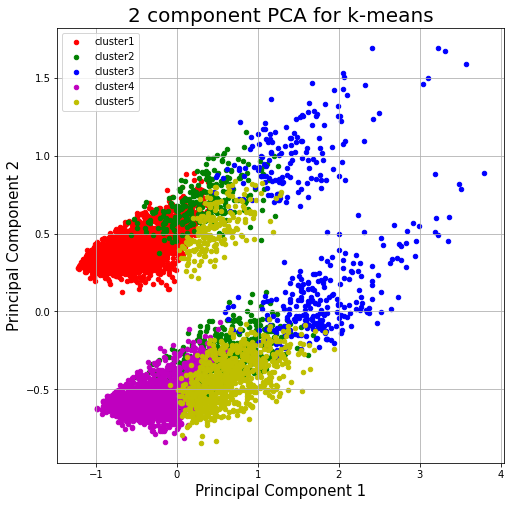

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for k-means', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmeans_clusters)):
  # for each cluster
  arr=df_clus_encoded_mm_pca2[kmeans_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], 
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i], 
             s = 20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

## 3-comp PCA visualization

In [ ]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
# my_st_scaler.fit(df_clus_encoded)  

# # tranform returns a numpy array which is perfect to pass into the kmedoids function
# df_clus_encoded_st = my_st_scaler.transform(df_clus_encoded)

In [ ]:
# instantiate PCA object
my_pca3 = PCA(n_components=3)
df_clus_encoded_mm_pca3 = my_pca3.fit_transform(df_clus_encoded_mm)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [ ]:
print(df_clus_encoded_mm.shape)
print(df_clus_encoded_mm_pca3.shape)

(5772, 47)
(5772, 3)


In [ ]:
len(df_clus_encoded_mm_pca3[kmedoids_clusters[0]][:,0])

1442

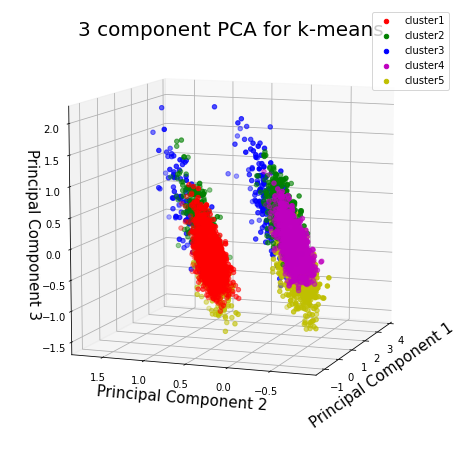

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA for k-means', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmeans_clusters)):
  # for each cluster
  arr=df_clus_encoded_mm_pca3[kmeans_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], arr[:,2],
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i],
             s=20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

# try different rotation angles here
ax.azim = 200
  # The azimuth is the rotation around the z axis e.g.:
  # 0 means "looking from +x"
  # 90 means "looking from +y"
ax.elev = 10
  #elev is the angle between the eye and the xy plane.

# ax.dist = 100
  # dist is the distance from the center visible point in data coordinates.
# plt.show()

## 2-comp TSNE visualization

In [ ]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
# my_st_scaler.fit(df_clus_encoded)  

# # tranform returns a numpy array which is perfect to pass into the kmedoids function
# df_clus_encoded_st = my_st_scaler.transform(df_clus_encoded)

In [ ]:
# instantiate tsne object
my_tsne2 = TSNE(n_components=2)

df_clus_encoded_mm_tsne2 = my_tsne2.fit_transform(df_clus_encoded_mm)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [ ]:
# # look into variance explained
# print(my_pca2.explained_variance_)
#   # The variance i.e. the eigenvalues of the covariance matrix
#   # The amount of variance explained by each of the selected components.
# print(my_pca2.explained_variance_ratio_)
#   # Percentage of variance explained by each of the selected components versue overall variance in the og data.
#   # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
# print(my_pca2.explained_variance_ratio_.cumsum())

In [ ]:
# look into Kullback-Leibler divergence after optimization.
# the lower the better
my_tsne2.kl_divergence_

2.489746332168579

In [ ]:
print(df_clus_encoded_mm.shape)
print(df_clus_encoded_mm_tsne2.shape)

(5772, 45)
(5772, 2)


In [ ]:
len(df_clus_encoded_mm_tsne2[kmeans_clusters[0]][:,0])

1883

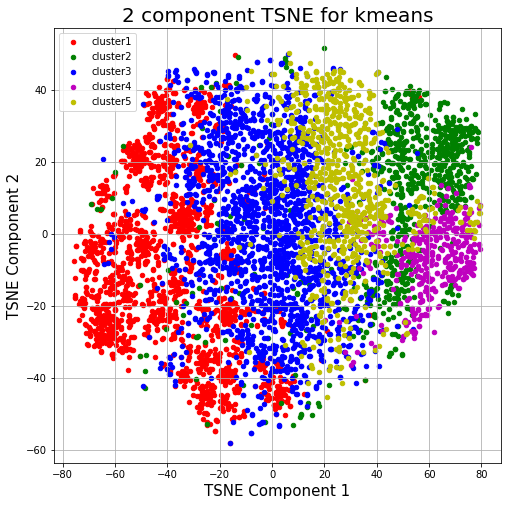

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE Component 1', fontsize = 15)
ax.set_ylabel('TSNE Component 2', fontsize = 15)
ax.set_title('2 component TSNE for kmeans', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmeans_clusters)):
  # for each cluster
  arr=df_clus_encoded_mm_tsne2[kmeans_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], 
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i], 
             s = 20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

plt.show()

## 3-comp TSNE visualization

In [ ]:
# despite the fact that PCA works with standardized data, we are just visualizing the clusters
# so we should keep the data normalization consistent with how our clusters see them

# # my_mm_scaler = MinMaxScaler()  
# my_st_scaler = StandardScaler()
#   # this is the only scaler that works with PCA
#   # but is this the best scaler for clustering purposes?
#   # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
# my_st_scaler.fit(df_clus_encoded)  

# # tranform returns a numpy array which is perfect to pass into the kmedoids function
# df_clus_encoded_st = my_st_scaler.transform(df_clus_encoded)

In [ ]:
# instantiate TSNE object
my_tsne3 = TSNE(n_components=3)
df_clus_encoded_mm_tsne3 = my_tsne3.fit_transform(df_clus_encoded_mm)
  # returns ndarray of shape (n_samples, n_components) Transformed values.

In [ ]:
# # look into variance explained
# print(my_pca3.explained_variance_)
#   # The variance i.e. the eigenvalues of the covariance matrix
#   # The amount of variance explained by each of the selected components.
# print(my_pca3.explained_variance_ratio_)
#   # Percentage of variance explained by each of the selected components versue overall variance in the og data.
#   # If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0
# print(my_pca3.explained_variance_ratio_.cumsum())

In [ ]:
# look into Kullback-Leibler divergence after optimization.
# the lower the better
my_tsne3.kl_divergence_

2.3159985542297363

In [ ]:
print(df_clus_encoded_mm.shape)
print(df_clus_encoded_mm_tsne3.shape)

(5772, 45)
(5772, 3)


In [ ]:
len(df_clus_encoded_mm_tsne3[kmeans_clusters[0]][:,0])

1883

matplotlib.axes._subplots.Axes3DSubplot

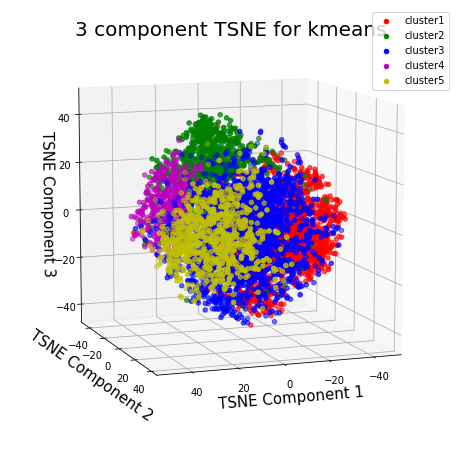

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('TSNE Component 1', fontsize = 15)
ax.set_ylabel('TSNE Component 2', fontsize = 15)
ax.set_zlabel('TSNE Component 3', fontsize = 15)
ax.set_title('3 component TSNE for kmeans', fontsize = 20)

colors = ['r', 'g', 'b','m','y','c']
for i in range(len(kmeans_clusters)):
  # for each cluster
  arr=df_clus_encoded_mm_tsne3[kmeans_clusters[i]]
    # grab the rows of that cluster
  ax.scatter(arr[:,0], arr[:,1], arr[:,2],
             # all rows of the first column as x, all rows of the second column as y
             c = colors[i],
             s=20)
  
ax.legend(['cluster'+str(i) for i in range(1,6)])
ax.grid()

# try different rotation angles here
ax.azim = 70
  # The azimuth is the rotation around the z axis e.g.:
  # 0 means "looking from +x"
  # 90 means "looking from +y"
ax.elev = 10
  #elev is the angle between the eye and the xy plane.
# ax.dist = 100
  # dist is the distance from the center visible point in data coordinates.
type(ax)

In [ ]:
!ls

 cleaned_data  'General presentation.gslides'   notebooks


## `pyclustering` pairwise visualization

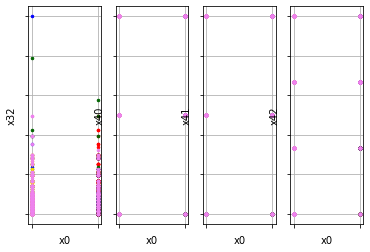

In [ ]:
# Display clusters.
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(kmeans_clusters, df_clus_encoded_mm.tolist())
  # only works with a list of lists, does NOT work with np array
visualizer.show(pair_filter=[[0, 32], [0, 40],[0,41],[0,42]])
# visualizer.show(max_row_size=3)

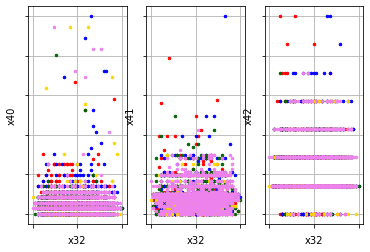

In [ ]:
visualizer.show(pair_filter=[[32, 40],[32,41],[32,42]])

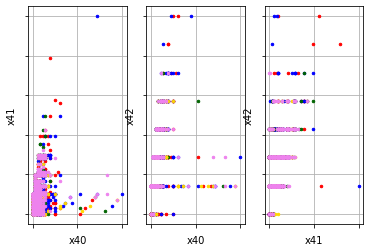

In [ ]:
visualizer.show(pair_filter=[[40,41],[40,42],[41,42]])

# grid-search for best `kmeans`

In [ ]:
df_clus_encoded = pd.read_csv('cleaned_data/df_cluster_encoded.csv')

# since this df was saved WITH the index, we have to re-assign it as the index and drop it from the columns
df_clus_encoded.set_index('eid',inplace=True)

In [ ]:
my_mm_scaler = MinMaxScaler()  
# my_scaler = StandardScaler()
  # this is the only scaler that works with PCA later
  # but is this the best scaler for clustering purposes?
  # no, it really changes cluster performance because unlike MM-scaler, ST-scaler changes the proprotion of distances
my_mm_scaler.fit(df_clus_encoded)  

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
# tranform returns a numpy array which is perfect to pass into the kmedoids function
df_clus_encoded_mm = my_mm_scaler.transform(df_clus_encoded)

In [ ]:
# since kmedoids does not have a .get_total_wce method
# we must manually design a function that returns sum of metric errors
# make sure it is the Sum of Squared Errors where each error is calculated using the metric the algorithm was trained on
# this matches how the kmeans internal function does it
def kmeans_total_sse(metric, data, centers, clusters):
  '''
  input:
    metric: the distance_metric object used by the clutering algoritm
    data: the data in numpy arrays containing the points
    centers: a list of points the final clusters
    clusters: a list of clusters, where each cluster is a list of indices in that cluster, 
              cannot be sorted and must be in the same order as medoids list
  output:
    the total sum of squared errors of between points and their cluster centers using the metric
  '''
  sse = 0
  assert len(centers) == len(clusters)
  for i in range(len(centers)):
    # for each center
    center = centers[i] # actual center point
    for j in clusters[i]:
      # for each index in the cluster with that center
      pt = data[j, :] # actual point in data
      sse += metric(pt,center) # error between point and center

  return sse

In [ ]:
# create euclidean distance metric
metric = distance_metric(type_metric.EUCLIDEAN)

In [ ]:
k_lst = [i for i in range(2,31)]
kmeans_error_lst=[]
kmeans_center_lst=[]
kmeans_sorted_clusters_lst=[]

for k in tqdm(k_lst):
  # Prepare k different initial centers using K-Means++ method.
  initial_centers = kmeans_plusplus_initializer(df_clus_encoded_mm, k).initialize()

    # Create instance of K-Medoids algorithm.
  kmeans_instance = kmeans(df_clus_encoded_mm.tolist(), 
                            initial_centers,
                            metric=metric)
  
  # Run cluster analysis and obtain results.
  # cluster only runs on a list of lists
  kmeans_instance.process()

  # show the final center averages for each cluster
  final_centers = kmeans_instance.get_centers()
  kmeans_center_lst.append(final_centers)

  # Show allocated clusters
  # each list is a cluster and contains the index of the rows in that cluster
  kmeans_clusters = kmeans_instance.get_clusters()

  # use unsorted cluster for error, so order is the same as center
  total_error = kmeans_instance.get_total_wce()
  # self_error = kmeans_total_sse(metric, df_clus_encoded_mm, final_centers, kmeans_clusters)
  # print(total_error, self_error)
  # I tested the above, the total_error returned by the method is the same as what my function returns
  kmeans_error_lst.append(total_error)

  # sort and save so order can be compared with kmeans later
  kmeans_clusters.sort()
  kmeans_sorted_clusters_lst.append(kmeans_clusters)


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


In [ ]:
len(final_centers)

30

In [ ]:
kmeans_i = kmeans_error_lst.index(min(kmeans_error_lst))

print(f'lowest SSE for kmeans: {kmeans_error_lst[kmeans_i]}')
print(f'best k for kmeans: {k_lst[kmeans_i]}')

lowest SSE for kmeans: 6474.674033472449
best k for kmeans: 30


In [ ]:
# kmeans_error_lst

Text(0.5, 1.0, 'grid search for kmeans')

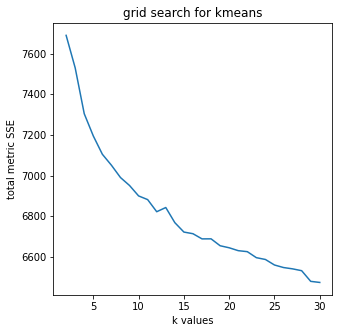

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(k_lst, kmeans_error_lst)
plt.xlabel("k values")
plt.ylabel("total metric SSE")
plt.title("grid search for kmeans")

In [ ]:
kmeans_grid_dict = {'k_lst': k_lst,
                    'error_lst': kmeans_error_lst,
                    'center_lst': kmeans_center_lst,
                    'sorted_clusters_lst': kmeans_sorted_clusters_lst}

In [ ]:
# save the grid search results for loading later
with open('cleaned_data/kmeans_grid_dict.json', 'w') as fp:
    json.dump(kmeans_grid_dict, fp, indent=4)


## add grid-search results to **original** dataframe

add `k=4~13`

In [ ]:
# later load with
with open('cleaned_data/kmeans_grid_dict.json', 'r') as fp:
    # kmeans_grid_dict_load = json.load(fp)
    kmeans_grid_dict = json.load(fp)

k_lst = kmeans_grid_dict['k_lst']
kmeans_error_lst = kmeans_grid_dict['error_lst']
kmeans_center_lst = kmeans_grid_dict['center_lst']
kmeans_sorted_clusters_lst = kmeans_grid_dict['sorted_clusters_lst']

In [ ]:
len(kmeans_sorted_clusters_lst[8])
  # the 8th k-value we've tried is 10

10

In [ ]:
# kmeans_grid_dict == kmeans_grid_dict_load

In [ ]:
# add cluster results to the original dataframe, where no features were encoded nor scaled nor removed

# df_result_grid = df.copy()
  # from kmedoid


ks = [13,12,11,10,9,8,7,6,5,4]

for k in ks: # for each k value of interest
  i = k_lst.index(k)
    # find the index of the k value of interest
  print(f'k-value:{k} is index {i}')

  feat = 'kmeans_cluster_' + str(k)
  print(f'adding column {feat}')
  
  df_result_grid[feat] = np.zeros(len(df_result_grid))
  # create a new column indicating the kmeans cluster with k clusters results

  kmeans_clusters = kmeans_sorted_clusters_lst[i]
  # grab the cluster results trained with the k-value

  assert len(kmeans_clusters) == k
    # make sure the number of clusters in the result match the chosen k
  
  for i in range(len(kmeans_clusters)): # for each cluster_i in the cluster_lst of the k
    # assign cluster number to the rows
    rows=kmeans_clusters[i]
      # get the row indices of samples in cluster_i
    col = df_result_grid.columns.get_loc(feat)
      # get the column index of the particular k-value 

    # df_result_grid.iloc[rows, col] = int(i+1), same as below
    df_result_grid.iloc[rows, col] = int(i+1)*np.ones(len(rows))
      # assign the cluster number to those rows of a particular k-kmeans

k-value:13 is index 11
adding column kmeans_cluster_13
k-value:12 is index 10
adding column kmeans_cluster_12
k-value:11 is index 9
adding column kmeans_cluster_11
k-value:10 is index 8
adding column kmeans_cluster_10
k-value:9 is index 7
adding column kmeans_cluster_9
k-value:8 is index 6
adding column kmeans_cluster_8
k-value:7 is index 5
adding column kmeans_cluster_7
k-value:6 is index 4
adding column kmeans_cluster_6
k-value:5 is index 3
adding column kmeans_cluster_5
k-value:4 is index 2
adding column kmeans_cluster_4


In [ ]:
df_result_grid.shape
  # should be (5772, 73), 20 more columns than all the original features

(5772, 73)

In [ ]:
df_result_grid.head()

,eid,31-0.0,53-2.0,20400-0.0,20458-0.0,20459-0.0,20460-0.0,20479-0.0,20485-0.0,20495-0.0,20497-0.0,20498-0.0,20505-0.0,20506-0.0,20507-0.0,20508-0.0,20509-0.0,20510-0.0,20511-0.0,20512-0.0,20513-0.0,20514-0.0,20515-0.0,20516-0.0,20517-0.0,20518-0.0,20519-0.0,20520-0.0,21003-2.0,21023-0.0,21025-0.0,21033-0.0,21034-0.0,21040-0.0,21041-0.0,21042-0.0,21043-0.0,21044-0.0,21048-0.0,21049-0.0,21051-0.0,21052-0.0,21053-0.0,21054-0.0,21055-0.0,21056-0.0,21057-0.0,21058-0.0,21059-0.0,21060-0.0,21061-0.0,center2_time_lapse1,center2_time_lapse2,kmedoid_cluster_13,kmedoid_cluster_12,kmedoid_cluster_11,kmedoid_cluster_10,kmedoid_cluster_9,kmedoid_cluster_8,kmedoid_cluster_7,kmedoid_cluster_6,kmedoid_cluster_5,kmedoid_cluster_4,kmeans_cluster_13,kmeans_cluster_12,kmeans_cluster_11,kmeans_cluster_10,kmeans_cluster_9,kmeans_cluster_8,kmeans_cluster_7,kmeans_cluster_6,kmeans_cluster_5,kmeans_cluster_4
0,1000993,1.0,2017-06-21,2016-07-28,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,59.0,2017-04-11,0.0,-500.0,-501.0,1.0,0.0,3.0,5.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,328 days,71 days,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1001367,1.0,2017-08-16,2016-09-30,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,78.0,2017-08-24,4.0,-503.0,-501.0,8.0,0.0,1.0,7.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,320 days,-8 days,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1003110,1.0,2016-05-25,2016-08-18,2.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,64.0,2017-04-28,0.0,-500.0,-501.0,1.0,0.0,2.0,6.0,1.0,-600.0,-602.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-85 days,-338 days,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1003823,1.0,2016-05-31,2016-08-24,2.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,59.0,2017-05-05,0.0,-501.0,-500.0,1.0,2.0,2.0,3.0,1.0,-600.0,-601.0,-601.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-601.0,-85 days,-339 days,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0
4,1004315,0.0,2017-09-15,2017-04-25,4.0,5.0,3.0,2.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,1.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,3.0,2.0,53.0,2017-04-25,3.0,-500.0,-501.0,1.0,1.0,2.0,5.0,1.0,-601.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,-313.0,-600.0,-601.0,-602.0,-601.0,143 days,143 days,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0


In [ ]:
# just to check if cluster numbers are assigned correctly
df_result_grid['kmedoid_cluster_4'].unique()

array([1., 2., 3., 4.])

In [ ]:
df_result_grid.groupby('kmedoid_cluster_4')['eid'].count()

kmedoid_cluster_4
1.0    1315
2.0    1009
3.0    1610
4.0    1838
Name: eid, dtype: int64

In [ ]:
# save to csv file WITHOUT INDEX for easier loading later
df_result_grid.to_csv('cleaned_data/df_result_grid.csv', index=False)
  # when loading later, make to to set the 'eid' column as the index

In [ ]:
test = pd.read_csv('cleaned_data/df_result_grid.csv')

In [ ]:
# should be 73 columns, 53+10 kmeans results + 10 kmedoids results
test.shape


(5772, 73)

# group-wise comparison of the two clusters

In [ ]:
df_result.shape
  # should be (5772, 49), 2 more columns than the features
  # the categorical columns are encoded but NOT normalized

(5772, 55)

In [ ]:
df_result.columns

Index(['eid', '31-0.0', '53-2.0', '20400-0.0', '20458-0.0', '20459-0.0',
       '20460-0.0', '20479-0.0', '20485-0.0', '20495-0.0', '20497-0.0',
       '20498-0.0', '20505-0.0', '20506-0.0', '20507-0.0', '20508-0.0',
       '20509-0.0', '20510-0.0', '20511-0.0', '20512-0.0', '20513-0.0',
       '20514-0.0', '20515-0.0', '20516-0.0', '20517-0.0', '20518-0.0',
       '20519-0.0', '20520-0.0', '21003-2.0', '21023-0.0', '21025-0.0',
       '21033-0.0', '21034-0.0', '21040-0.0', '21041-0.0', '21042-0.0',
       '21043-0.0', '21044-0.0', '21048-0.0', '21049-0.0', '21051-0.0',
       '21052-0.0', '21053-0.0', '21054-0.0', '21055-0.0', '21056-0.0',
       '21057-0.0', '21058-0.0', '21059-0.0', '21060-0.0', '21061-0.0',
       'center2_time_lapse1', 'center2_time_lapse2', 'kmedoid_cluster',
       'kmeans_cluster'],
      dtype='object')

In [ ]:
# columns of interest
cols = ['21034-0.0','20511-0.0','20509-0.0','20497-0.0','20479-0.0']

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


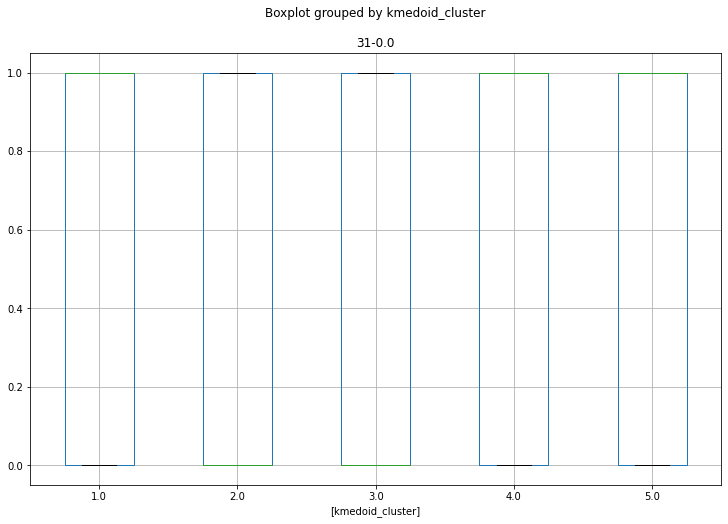

In [ ]:
df_result.boxplot(column=['31-0.0'], by=['kmedoid_cluster'],figsize=(12,8))

# k-medoids with gower on our data

## setup gower distance

ower Distance is a distance measure that can be used to calculate distance between two entity whose attribute has a mixed of categorical and numerical values, which fits our use case. 

View how it works [here](https://medium.com/analytics-vidhya/gowers-distance-899f9c4bd553).

View API [here](https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/).

In [ ]:
euclid_metric = distance_metric(type_metric.EUCLIDEAN)
euclid_metric([3, 0], [0,4])

5.0

In [ ]:
# User may define its own function for distance calculation.
# In this case input is two points.

In [ ]:
gower.gower_matrix(df_clus)

array([[ 0.        , -0.01309858,  0.00095213, ...,  0.00088414,
         0.0266407 ,  0.04536565],
       [-0.01309858,  0.        ,  0.01461027, ...,  0.00769085,
         0.01288683,  0.04207953],
       [ 0.00095213,  0.01461027,  0.        , ..., -0.00961742,
         0.02528162,  0.03267866],
       ...,
       [ 0.00088414,  0.00769085, -0.00961742, ...,  0.        ,
         0.00764198,  0.04965576],
       [ 0.0266407 ,  0.01288683,  0.02528162, ...,  0.00764198,
         0.        ,  0.02759229],
       [ 0.04536565,  0.04207953,  0.03267866, ...,  0.04965576,
         0.02759229,  0.        ]], dtype=float32)

In [ ]:
df_clus_encoded.iloc[[0],:]

,1920-2.0,1930-2.0,1940-2.0,1950-2.0,1960-2.0,1970-2.0,1980-2.0,1990-2.0,2000-2.0,2010-2.0,2020-2.0,2030-2.0,2050-2.0,2060-2.0,2070-2.0,2080-2.0,20505-0.0,20506-0.0,20507-0.0,20508-0.0,20509-0.0,20510-0.0,20511-0.0,20512-0.0,20513-0.0,20514-0.0,20515-0.0,20516-0.0,20517-0.0,20518-0.0,20519-0.0,20520-0.0,21003-2.0,21024-0.0,21033-0.0,21034-0.0,21035-0.0,21038-0.0,21040-0.0,21041-0.0,21042-0.0,21043-0.0,21044-0.0,21048-0.0,21049-0.0,21051-0.0,21052-0.0,21053-0.0,21054-0.0,21055-0.0,21056-0.0,21058-0.0,21059-0.0,21060-0.0,21061-0.0,21064-0.0,21065-0.0,21068-0.0,31-0.0,21025-0.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1020090.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,4.0,1.0,1.0,2.0,49.0,2.0,3.0,4.0,1.0,1.0,8.0,1.0,4.0,7.0,2.0,1.0,1.0,3.0,3.0,3.0,3.0,2.0,0.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0


In [ ]:
col_is_cat = df_clus_encoded.columns.isin(cat_cols)

In [ ]:
gower.gower_matrix(df_clus_encoded.iloc[[0]],df_clus_encoded.iloc[[1]])
  # we can just select 2 rows and compute their gower distance, BUT ONLY UNDER THE RESTRICTION
  # that they are both dataframes, with columns
  # else the code cannot process correctly

array([[0.33333334]], dtype=float32)

In [ ]:
# we should specify which columns are categorical, because it might not infer correctly by itself

gower.gower_matrix(df_clus_encoded.iloc[[0]],df_clus_encoded.iloc[[1]],
                   cat_features=col_is_cat)
  # we can just select 2 rows and compute their gower distance, BUT ONLY UNDER THE RESTRICTION
  # that they are both dataframes, with columns
  # else the code cannot process correctly

array([[0.33333334]], dtype=float32)

In [ ]:
euclid_metric(df_clus_encoded.iloc[0],df_clus_encoded.iloc[1])
# we can see it is definitely different then Euclidean distance

16.401219466856727

In [ ]:
# user_defined can only be defined on 2 arguments!
def gower_dis(point1, point2):
    result = gower.gower_matrix(point1,
                                point2,
                                cat_features=col_is_cat)
    return result

gower_metric = distance_metric(type_metric.USER_DEFINED, func=gower_dis)
gower_metric(df_clus_encoded.iloc[[0]], df_clus_encoded.iloc[[1]])

array([[0.33333334]], dtype=float32)

In [ ]:
# now the problem becomes, when kmedoids select 2 points to feed into this metric, are they treated as 1-row dfs?
# will their column information be maintained for our gower_matrix function?

In [ ]:
kmedoids_instance = kmedoids(df_clus_encoded, initial_medoids)
kmedoids_instance.process()
# the kmedoids function cannot even takein dataframes!
# we must convert our dataframes into numpy arrays first
# then in the distance function, convert each row into a dataframe with column names, then the gower_matrix function would work
# but other problem arises, see notes in 4/13 meeting

KeyError: ignored

In [ ]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(df_clus_encoded)